https://www.kaggle.com/c/ds2-predictive-modeling-challenge

In [103]:
##TODO:
# PCA on similar features
# pygeohash

In [1]:
import folium
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.spatial import ConvexHull
from scipy.spatial.qhull import QhullError
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

plt.style.use('seaborn')

pd.options.display.max_columns = None
pd.options.display.max_rows = 100

In [2]:
feats_info = {
    'amount_tsh' :           'Total static head (amount water available to waterpoint)',
    'date_recorded' :        'The date the row was entered',
    'funder' :               'Who funded the well',
    'installer' :            'Organization that installed the well',
    'wpt_name' :             'Name of the waterpoint if there is one',
#     'num_private' :          '', # Empty
    
    'gps_height' :           'Altitude of the well',
    'longitude' :            'GPS coordinate',
    'latitude' :             'GPS coordinate',
    'basin' :                'Geographic water basin',
    'subvillage' :           'Geographic location',
    'region' :               'Geographic location',
#     'region_code' :          'Geographic location (coded)', # less consistent than `region`
#     'district_code' :        'Geographic location (coded)',
    'lga' :                  'Geographic location',
    'ward' :                 'Geographic location',
    
    'population' :           'Population around the well',
    'public_meeting' :       'True/False',
#     'recorded_by' :          'Group entering this row of data', # single value
    'scheme_management' :    'Who operates the waterpoint',
    'scheme_name' :          'Who operates the waterpoint',
    'permit' :               'If the waterpoint is permitted',
    'construction_year' :    'Year the waterpoint was constructed',
    
#     'extraction_type' :      'The kind of extraction the waterpoint uses',
    'extraction_type_group': 'The kind of extraction the waterpoint uses',
#     'extraction_type_class': 'The kind of extraction the waterpoint uses',
    
    'management' :           'How the waterpoint is managed',
    'management_group' :     'How the waterpoint is managed',
    
    'payment' :              'What the water costs',
    'payment_type' :         'What the water costs',
    
#     'water_quality' :        'The quality of the water', # almost 100% redundant
    'quality_group' :        'The quality of the water',
    'quantity' :             'The quantity of water',
#     'quantity_group' :       'The quantity of water',
    
    'source' :               'The source of the water',
    'source_type' :          'The source of the water',
    'source_class' :         'The source of the water',
    
    'waterpoint_type' :      'The kind of waterpoint',
    'waterpoint_type_group' :'The kind of waterpoint',
}

geog_feats = [k for k, v in feats_info.items() if 'geog' in v.lower() or 'gps' in v.lower()]

In [91]:
def my_describe(df):
    described = (df.describe(include='all').T
                   .join(pd.DataFrame({'NaNs_%':df.isna().sum()/len(df)*100, 
                                       'dtype':df.dtypes.astype(str)})))

    return described.sort_index()


def load():
    X_train = pd.read_csv('datasets/train_features.csv', index_col=0)
    X_test  = pd.read_csv('datasets/test_features.csv', index_col=0)
    y_train = pd.read_csv('datasets/train_labels.csv', index_col=0)
    y_test = None
    
    return X_train, X_test, y_train, y_test


def clean_cols(df):
    df.loc[:, 'date_recorded'] = pd.to_datetime(df['date_recorded'])
#     df['region_code'] = df['region_code'].astype('object')

    # map to standard NaN
    nan_vals = {'installer':['0', 'not known'],
                'funder':['0'],
                'wpt_name':['none'],
                'construction_year':[0],
                'population':[0],
                'longitude':[0],
                'latitude':[-2e-08],
                'gps_height':[0],
               }

    for col in df.select_dtypes(exclude=['number', 'datetime64']):
        if col=='status_group':
            continue
        df.loc[:, col] = df[col].fillna('')
        df.loc[:, col] = df[col].astype(str).str.lower()
        nan_map = {k:'' for k in nan_vals.get(col, [''])}
        df.loc[:, col] = df[col].replace(nan_map)
        df.loc[:, col] = df[col].replace({'':'NONE'})      
    
    for col in df.select_dtypes(include='number'):
        nan_map = {k:np.nan for k in nan_vals.get(col, [np.nan])}
        df.loc[:, col] = df[col].replace(nan_map)
    
    govt_alias = ['government', 'central government', 'gover', 'gove', 'central govt']
    df.loc[:, 'installer'] = df['installer'].str.replace('|'.join(govt_alias), 'government')
    
#     for col in df.select_dtypes(exclude=['number', 'datetime64']):
#         df.loc[:, col] = df[col].astype('category')

    return df


def log_reg_pairplot(df, x_vars, y_lab='status_group'):
    if isinstance(x_vars, str):
        x_vars = [x_vars]
        
    x_frame = pd.get_dummies(df[x_vars])      
    x_vars = x_frame.columns
    
    y_frame = pd.get_dummies(df[y_lab])
    y_vars = y_frame.columns
    
    df = x_frame.join(y_frame)

    plot = sns.pairplot(data=df, x_vars=x_vars, y_vars=y_vars, kind='reg',
                        plot_kws={'logistic':True, 'line_kws':{'color':'red'},
                                  'scatter_kws':{'alpha':0.1, 'linewidth':0}})
    return plot


def impute_lat_lon_pop(df, aggs, label):
    df = df.merge(aggs, left_on=label, right_index=True, 
                  how='left', suffixes=('', f'_{label}'))
    
    mask = (df['longitude'].isna() | (df['longitude']==0) | 
            df['latitude'].isna()  | (df['latitude'] == 0))
    df.loc[mask, 'longitude'] = df.loc[mask, f'longitude_{label}']
    df.loc[mask, 'latitude'] = df.loc[mask, f'latitude_{label}']
    
    if 'label' == 'lga':
        mask = df['gps_height'].isna()
        df.loc[mask, 'gps_height'] = df.loc[mask, f'gps_height_{label}']
    
    mask = df['population'].isna() | (df['population'] == 0)
    df.loc[mask, ['population']] = df.loc[mask, f'population_{label}']
    
    drop_cols = [f'population_{label}', f'longitude_{label}',
                 f'latitude_{label}', f'gps_height_{label}']
    
    df = df[[col for col in df if col not in drop_cols]]
    
    return df


def feature_engineering(df):
    # numerics converted to categories here due to NaNs and clustered distribution
    df['age_years'] = (df['date_recorded'] - pd.to_datetime(df['construction_year'])).dt.days // 365
    df['age_years'] = df['age_years'].astype(str)#.astype('category')

    df['construction_half_decade'] = df['construction_year'] // 5 * 5
    df['construction_half_decade'] = df['construction_half_decade'].astype(str)#.astype('category')

    df['year_recorded'] = df['date_recorded'].dt.year
    df['month_recorded'] = df['date_recorded'].dt.month.astype(str)#.astype('category')

    del df['construction_year'], df['date_recorded']

    return df


def reduce_cardinality(df, max_rank=12, min_percent=0.01):
    for col in df.select_dtypes(exclude=['number', 'datetime64']):
        counts = df[col].value_counts(normalize=True)
        keep_cats = counts.loc[counts >= min_percent].index[:max_rank]
        df.loc[~df[col].isin(keep_cats), col] = 'NONE'

    return df


def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371000):
    """Vectorized great circle distance between two points
    
    lat, lon: specified in decimal degrees or in radians
    returns: array of units in meters
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


def dist_to_group_center(df, group_col='basin'):
    lats = {}
    lons = {}

    grouped = df.groupby(group_col)
    for group_name, group_df in grouped:
        points = list(zip(group_df.latitude, group_df.longitude))

        hull = ConvexHull(points)
        form = [points[i] for i in hull.vertices]

        lats[group_name] = np.mean(hull.points[hull.vertices,0])
        lons[group_name] = np.mean(hull.points[hull.vertices,1])
    
    centroids_df = (pd.DataFrame([lats, lons]).T
                      .rename(columns={0:f'{group_col}_lat', 
                                       1:f'{group_col}_lon'}))
    
    df = df.merge(centroids_df, left_on=group_col, right_index=True)
    
    df[f'dist_to_{group_col}'] = haversine(df.latitude, df.longitude, 
                                           df[f'{group_col}_lat'], df[f'{group_col}_lon'])
    
    del df[f'{group_col}_lat'],  df[f'{group_col}_lon']
    
    return df


def pipeline(X, feats_info, X_train=None, training=True):
    keep_cols = list(feats_info.keys())
    keep_cols.append('status_group')
    X = X[[col for col in X if col in keep_cols]]
    print('cleaning')
    X = clean_cols(X)

    # Impute from `lga` and `region`
    if training:
        X_train = X.copy()
    else:
        X_train = X_train[[col for col in X if col in keep_cols]]
        X_train = clean_cols(X_train)

    print('imputing')
    lga_means = (X_train.groupby('lga')
                        .agg({'latitude':'mean',
                              'longitude':'mean',
                              'population':'mean',
                              'gps_height':'mean'}))

    reg_means = (X_train.groupby('region')
                        .agg({'latitude':'mean',
                              'longitude':'mean',
                              'population':'mean'}))

    X = impute_lat_lon_pop(df=X, aggs=lga_means, label='lga')
    X = impute_lat_lon_pop(df=X, aggs=reg_means, label='region')
    print('feature engineering')
    X = feature_engineering(X)

    if training:
        print('reducing cardinality')
        X = reduce_cardinality(X)

    return X


def map_latlon_df(df, map_obect=None, frac=1, tiles="CartoDB dark_matter"):
    if not map_obect:
        map_obect = folium.Map(
            location=[df.latitude.mean(), df.longitude.mean()],
            zoom_start=6,
            tiles=tiles
        )

    for i, r in df.sample(frac=frac).iterrows():
        try:
            folium.CircleMarker(
                location=[r.latitude, r.longitude],
                radius=2,
                color='lightblue',
                fill=True,
                fill_color='lightskyblue'
            ).add_to(map_obect)
        except ValueError as e:
            continue

    return map_obect


def RGB_to_hex(RGB):
    ''' [255,255,255] -> "#FFFFFF" '''
    # Components need to be integers for hex to make sense
    RGB = [int(x) for x in RGB]
    return "#"+"".join(["0{0:x}".format(v) if v < 16 else
              "{0:x}".format(v) for v in RGB])


def rand_hex_color(num=1):
    ''' Generate random hex colors, default is one,
        returning a string. If num is greater than
        1, an array of strings is returned. '''
    colors = [
        RGB_to_hex([x*255 for x in np.random.rand(3)])
        for i in range(num)
    ]
    if num == 1:
        return colors[0]
    else:
        return colors


def plot_convex_hulls(df, hull_group_col=None, point_group_col=None, fraction_points_plot=0, 
                      tiles="CartoDB dark_matter"):    
    m = folium.Map(
        location=[df.latitude.mean(), df.longitude.mean()],
        zoom_start=6,
        tiles=tiles
    )
    
    if hull_group_col:
        failed = {}
        grouped = df.groupby(hull_group_col)
        for group_name, group_df in grouped:
#             group_df = group_df.loc[~group_df.longitude.isna()]
            points = list(zip(group_df.latitude, group_df.longitude))

            try:
                hull = ConvexHull(points)
                form = [points[i] for i in hull.vertices]

                folium.Polygon(locations=form, color='lightblue', 
                               fill_color='lightskyblue', weight=2, 
                               popup=(folium.Popup(group_name))).add_to(m)
            except (QhullError, ValueError) as e:
                failed[group_name] = e
                continue

    if point_group_col:
        unq = df[point_group_col].unique()
        n_colors = len(unq)
        colors = rand_hex_color(n_colors)
        color_map = {k:v for k, v in list(zip(unq, colors))}
        df[point_group_col] = df[point_group_col].map(color_map)
    
    if fraction_points_plot > 0:
        iterator = (df.loc[~df.longitude.isna()]
                      .sample(frac=fraction_points_plot)
                      .iterrows())
        for i, r in iterator:
            if point_group_col:
                color=r[point_group_col]
            else:
                color='lightblue'
                
            folium.CircleMarker(
                location=[r.latitude, r.longitude],
                radius=2,
                color=color,
                fill=True,
                fill_color=color,
            ).add_to(m)

    if failed:
        print(failed)

    return m

## Explore

In [55]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

In [11]:
pd.crosstab(index=df.extraction_type_group, columns=df.status_group, 
            dropna=False, normalize='index')

status_group,functional,functional needs repair,non functional
extraction_type_group,,,
afridev,0.677966,0.023729,0.298305
gravity,0.599253,0.100859,0.299888
india mark ii,0.603333,0.032917,0.363750
india mark iii,0.448980,0.010204,0.540816
mono,0.377661,0.045026,0.577312
nira/tanira,0.664827,0.078612,0.256561
other,0.160031,0.032037,0.807932
other handpump,0.472527,0.054945,0.472527
other motorpump,0.434426,0.073770,0.491803


In [43]:
# pd.crosstab(index=pd.qcut(df.population, 5).astype(str), 
#             columns=df.status_group, 
#             dropna=False, normalize='index')

# pd.crosstab(index=pd.cut(df.population, 10).astype(str), 
#             columns=df.status_group, dropna=False, 
#             normalize='index')

# pd.crosstab(index=pd.cut(df.gps_height, 10).astype(str), 
#             columns=df.status_group, dropna=False, 
#             normalize='index')

# pd.crosstab(index=df.extraction_type.astype(str), 
#             columns=df.status_group, dropna=False, 
#             normalize='index')

## Impute `population` and `latitude`/`longitude` from geographic group membership?

In [96]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

In [69]:
condition = df.population.isna() | (df.population == 0)
df['pop_nan'] = condition

m = plot_convex_hulls(df, hull_group_col='lga', 
                      point_group_col="pop_nan", 
                      fraction_points_plot=0.2)
m.save("lga_hulls_pop_nan_group.html")

{'Geita': QhullError('QH6013 qhull input error: input is less than 2-dimensional since it has the same x coordinate\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1803805389  incidence  Qtriangulate  _pre-merge  _zero-centrum\n  _max-width  0  Error-roundoff 1.3e-23  _one-merge 6.7e-23\n  _near-inside 3.4e-22  Visible-distance 2.7e-23  U-coplanar-distance 2.7e-23\n  Width-outside 5.4e-23  _wide-facet 1.6e-22\n',), 'Nyamagana': QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1803805389  incidence  Qtriangulate  _pre-merge  _zero-centrum\n',)}


[map here](lga_hulls_pop_nan_group.html)

In [97]:
condition = df.population.isna() | (df.population == 0)
lga_means = (df.loc[~condition].groupby('lga')
               .agg({'latitude':'mean',
                     'longitude':'mean',
                     'population':'mean',
                     'gps_height':'mean'}))

reg_means = (df.loc[~condition].groupby('region')
               .agg({'latitude':'mean',
                     'longitude':'mean',
                     'population':'mean'}))

In [98]:
df = impute_lat_lon_pop(df=df, aggs=lga_means, label='lga')
df = impute_lat_lon_pop(df=df, aggs=reg_means, label='region')

In [72]:
(df.longitude.isna() | (df.longitude == 0)).sum()

0

In [73]:
(df.population.isna() | (df.population == 0)).sum()

12115

In [74]:
condition = df.population.isna() | (df.population == 0)
df['pop_nan'] = condition

m = plot_convex_hulls(df, hull_group_col='lga', 
                      point_group_col="pop_nan", 
                      fraction_points_plot=0.2)
m.save("lga_hulls_pop_nan_group_imputed.html")

{'Geita': QhullError('QH6013 qhull input error: input is less than 2-dimensional since it has the same x coordinate\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1804427248  incidence  Qtriangulate  _pre-merge  _zero-centrum\n  _max-width  0  Error-roundoff 2.3e-14  _one-merge 1.2e-13\n  _near-inside 5.8e-13  Visible-distance 4.6e-14  U-coplanar-distance 4.6e-14\n  Width-outside 9.2e-14  _wide-facet 2.8e-13\n',), 'Nyamagana': QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1804427248  incidence  Qtriangulate  _pre-merge  _zero-centrum\n',)}


[map here](lga_hulls_pop_nan_group_imputed.html)

## Impute missing `gps_height` from nearest point? No.

This could be useful for a minority of points. Most points that are missing `gps_height` are deeply nested thin a cluster of points that also are missing `gps_height`. For example:
https://stackoverflow.com/questions/38965720/find-closest-point-in-pandas-dataframes

In [99]:
df['gps_height'] = df['gps_height'].replace({0:np.nan})
df['gps_height_nan'] = df['gps_height'].isna()

In [100]:
# can/should we do this? How many poinst are missing gps_height but AREN'T missing lat/lon?
len(df.loc[df['gps_height'].isna() & ~df.longitude.isna()])

20438

In [102]:
m = plot_convex_hulls(df, hull_group_col='lga', 
                      point_group_col='gps_height_nan', 
                      fraction_points_plot=0.2)
m.save("missing_gps_height_color.html")

{'Geita': QhullError('QH6013 qhull input error: input is less than 2-dimensional since it has the same x coordinate\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1822242668  incidence  Qtriangulate  _pre-merge  _zero-centrum\n  _max-width  0  Error-roundoff 2.3e-14  _one-merge 1.2e-13\n  _near-inside 5.8e-13  Visible-distance 4.6e-14  U-coplanar-distance 4.6e-14\n  Width-outside 9.2e-14  _wide-facet 2.8e-13\n',), 'Nyamagana': QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 1822242668  incidence  Qtriangulate  _pre-merge  _zero-centrum\n',)}


[map](missing_gps_height_color.html)

## Naive Model

In [3]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

df.status_group.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

## Beat the Naive Model - No Cleaning

In [42]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

described = my_describe(X_train)
cols = described.loc[described['dtype'].isin(('int64', 'float64')) | 
                     (described['unique'] < 20)].index

X_train = X_train[cols]
X_test = X_test[cols]

y_train = y_train['status_group']

In [33]:
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RobustScaler(),
    LogisticRegression(solver='lbfgs', multi_class='multinomial')
)

scores = cross_validate(pipe, X_train, y_train, n_jobs=-1,
                        cv=3, scoring='accuracy', 
                        return_train_score=True, 
                        return_estimator=True)

scores['test_score']

In [44]:
pipe.fit(X_train, y_train)

predictions = pipe.predict(X_test)

C:\Users\City_Year\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(cols=['basin', 'extraction_type', 'extraction_type_class', 'extraction_type_group', 'management', 'management_group', 'payment', 'payment_type', 'permit', 'public_meeting', 'quality_group', 'quantity', 'quantity_group', 'recorded_by', 'scheme_management', 'sour...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [ ]:
sumbission = (pd.DataFrame({'id':X_test.index, 
                            'status_group':predictions)
sumbission.to_csv('datasets/submission_01.csv', index=False)

## Engineering

In [4]:
X_train, X_test, y_train, y_test = load()

In [5]:
# X_test = pipeline(X_test, feats_info, X_train=X_train, training=False)
X_train = pipeline(X=X_train, feats_info=feats_info, 
                   X_train=None, training=True)

X_train.loc[X_train['population'].isna(), 'population'] = X_train['population'].median()
X_train.loc[X_train['gps_height'].isna(), 'gps_height'] = X_train['gps_height'].median()

y_train = y_train['status_group']

cleaning


C:\Users\City_Year\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


imputing
feature engineering
reducing cardinality


In [24]:
pipe = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    RobustScaler(),
    LogisticRegression(solver='lbfgs', 
                       multi_class='multinomial')
)

scores = cross_validate(pipe, X_train, y_train, n_jobs=-1,
                        cv=3, scoring='accuracy', 
                        return_train_score=True, 
                        return_estimator=True)

scores['test_score']

array([0.73863636, 0.73661616, 0.73929293])

In [12]:
pipe.fit(X_train, y_train)

sumbission = (pd.DataFrame({'id':X_test.index, 
                            'status_group':gs.predict(X_test)}))
sumbission.to_csv('datasets/submission_02.csv', index=False)

## Random Forest

In [149]:
X_train, X_test, y_train, y_test = load()

In [ ]:
# X_test = pipeline(X_test, feats_info, X_train=X_train, training=False)
X_train = pipeline(X=X_train, feats_info=feats_info, 
                   X_train=None, training=True)

X_train.loc[X_train['population'].isna(), 'population'] = X_train['population'].median()
X_train.loc[X_train['gps_height'].isna(), 'gps_height'] = X_train['gps_height'].median()

y_train = y_train['status_group']

In [ ]:
# df.waterpoint_type = pd.factorize(df.waterpoint_type)[0]
# df.payment_type = pd.factorize(df.payment_type)[0]
# df.water_quality = pd.factorize(df.water_quality)[0]
# df.scheme_management = pd.factorize(df.scheme_management)[0]

In [29]:
pipe = make_pipeline(
    # TODO factorize categories?
    ce.OneHotEncoder(use_cat_names=True), 
#     RobustScaler(),
    RandomForestClassifier(n_estimators=100)
)

scores = cross_validate(pipe, X_train, y_train, n_jobs=-1,
                        cv=3, scoring='accuracy', 
                        return_train_score=True, 
                        return_estimator=True)

scores['test_score']

array([0.80005051, 0.80030303, 0.79813131])

In [21]:
pipe.fit(X_train, y_train)

array([[7.20000000e-01, 1.00000000e-01, 1.80000000e-01],
       [7.11771177e-01, 1.67243886e-01, 1.20984937e-01],
       [7.30000000e-01, 1.70000000e-01, 1.00000000e-01],
       ...,
       [8.22145026e-01, 4.30655394e-02, 1.34789434e-01],
       [5.36554380e-01, 2.93491142e-01, 1.69954478e-01],
       [3.66162257e-04, 3.30248166e-05, 9.99600813e-01]])

In [70]:
sumbission = (pd.DataFrame({'id':X_test.index,
                            'status_group':pipe.predict(X_test)}))
sumbission.to_csv('datasets/submission_03.csv', index=False)

## Mapping

In [ ]:
# find locations of basins
# dist from population clusters
# dist from basins
# dist from country center

In [9]:
X_train, X_test, y_train, y_test = load()
df = X_train.join(y_train)

In [ ]:
df = df.loc[df.longitude > 0]

In [43]:
# m = plot_convex_hulls(df, group_col='basin', fraction_points_plot=0.1)

In [38]:
plot_convex_hulls(df, group_col='lga')

{'geita': QhullError('QH6013 qhull input error: input is less than 2-dimensional since it has the same x coordinate\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 831621281  incidence  Qtriangulate  _pre-merge  _zero-centrum\n  _max-width  0  Error-roundoff 2.3e-14  _one-merge 1.2e-13\n  _near-inside 5.8e-13  Visible-distance 4.7e-14  U-coplanar-distance 4.7e-14\n  Width-outside 9.3e-14  _wide-facet 2.8e-13\n',), 'nyamagana': QhullError('QH6214 qhull input error: not enough points(1) to construct initial simplex (need 3)\n\nWhile executing:  | qhull i Qt\nOptions selected for Qhull 2015.2.r 2016/01/18:\n  run-id 831621281  incidence  Qtriangulate  _pre-merge  _zero-centrum\n',)}


In [19]:
m = plot_convex_hulls(df, group_col='region', fraction_points_plot=0.1)
m.save('region_10_percent_points.html')

In [14]:
m.save('map.html')

In [8]:
df = append_dist_to_group_center(df, group_col='basin')

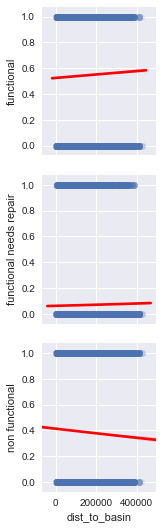

In [10]:
sns.pairplot(data=pd.get_dummies(df['status_group']).join(df['dist_to_basin']),
             x_vars='dist_to_basin', 
             y_vars=['functional', 'functional needs repair', 'non functional'],
             kind='reg',
             plot_kws={'logistic':True, 'line_kws':{'color':'red'},
                       'scatter_kws': {'alpha': 0.1}});